# Table of Contents

## 1 Data Import
#### 1.1 Importing Python Libraries
#### 1.2 Importing Excel Data <br>

## 2 Defining Global Parameters
#### 2.1 Time Related Parameters
#### 2.2 Finance Related Parameters
#### 2.3 Traffic Projections 
#### 2.4 Port Element Specification
#### 2.5 Existing Port Infrastructure<br>

## 3 Cash Flows
#### 3.1 Revenue Calculations
#### 3.2 Capex Calculations
#### 3.3 Opex Calclulations
#### 3.4 Demurrage Cost Calculations
#### 3.5 Residual Asset Calculations <br>

## 4 Port Optimization
<br>

# 1 Data Import
- 1.1 Importing Python Libraries
- 1.2 Importing Excel Data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 1.1 Importing Python Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import itertools
from sys import getsizeof
import timeit

## 1.2 Importing Excel Data 

In [3]:
################################################################################

# Read excel data

df_tf                = pd.read_excel ('Excel_input.xlsx', 'TF')
df_vs                = pd.read_excel ('Excel_input.xlsx', 'Vessel specs')
df_vd                = pd.read_excel ('Excel_input.xlsx', 'Vessel distribution')
df_single_parameters = pd.read_excel ('Excel_input.xlsx', 'Single parameters')
df_equipment_specs   = pd.read_excel ('Excel_input.xlsx', 'Equip specs')
df_handling_fees     = pd.read_excel ('Excel_input.xlsx', 'Handling fees')
df_ownership         = pd.read_excel ('Excel_input.xlsx', 'Ownership')
df_existing_port     = pd.read_excel ('Excel_input.xlsx', 'Existing port')

################################################################################

# Dataframe lookup function

def lookup(aspect,dataframe,jumps): 
    for i in range (len(dataframe)):
        if dataframe.iloc [i,0] == aspect:
            return dataframe.iloc[i,jumps]
        
################################################################################

def row_nr(aspect, dataframe, column):
    return dataframe.loc[dataframe[column]== aspect].index[0]

################################################################################

def column_nr(aspect, dataframe):
    return dataframe.columns.get_loc(aspect)

################################################################################

# 2 Defining Global Parameters
- 2.1 Time Related Parameters
- 2.2 Traffic Projections
- 2.3 Finance Related Parameters
- 2.4 Port Element Specifications

## 2.1 Time Related Parameters

In [4]:
################################################################################################################################

# Time related parameters

start_year = df_tf.iloc [0,0]
end_year   = df_tf.iloc [(len(df_tf)-1),0]
n_years    = int(end_year - start_year + 1)
n_a        = int(df_single_parameters.iloc [0,1]) 

################################################################################################################################

## 2.2 Traffic Projections
- 2.2.1 Traffic Forecast
- 2.2.2 Traffic Throughput

## 2.3 Finance Related Parameters
- 2.3.1 WACC calc (linked to ownership)
- 2.3.2 Depreciation calc 
- 2.3.3 Escalation calc
- 2.3.4 Inflation correction (for historic prices) 
- 2.3.5 Currency exchange rate (€ : $)

### 2.3.1 WACC calculation

In [5]:
################################################################################

# Ownership of the different terminal elements

def ownership (aspect):
    
    for i in range (len(df_ownership)):
        if df_ownership.iloc [i,0] == aspect:
            return df_ownership.iloc[i,1]

################################################################################

# The nominal WACC of both entities (Port Authority and Terminal Operator)

real_WACC_PA   = lookup('Real WACC Port Authority'   ,df_single_parameters,1)
real_WACC_TO   = lookup('Real WACC Terminal Operator',df_single_parameters,1)
inflation_rate = lookup('Inflation rate'             ,df_single_parameters,1)
PA_WACC        = np.zeros (n_years)
TO_WACC        = np.zeros (n_years)

for i in range (n_years):
    PA_WACC[i] = 1 / ((1 + real_WACC_PA + inflation_rate)**(i))
    TO_WACC[i] = 1 / ((1 + real_WACC_TO + inflation_rate)**(i))

PA_WACC = PA_WACC.reshape((-1, 1))
TO_WACC = TO_WACC.reshape((-1, 1))
        
################################################################################

# Determining the applicable WACC in a specific year

def WACC(aspect):
    
    if ownership(aspect) == 'Port authority':
        return PA_WACC
    if ownership(aspect) == 'Terminal operator':
        return TO_WACC
    
################################################################################

### 2.3.2 Depreciation calculation

In [6]:
# Annual depreciation

def depreciation(rate):

    selling_penalty   = 0.10
    depreciation_vector = np.zeros(n_years)
    
    for i_1 in range (n_years):
        depreciation_vector[i_1] = (1-selling_penalty) * ((1 - rate)**(i_1))
    return depreciation_vector

### 2.3.3 Escalation calculation

In [7]:
# Defining all escalation factors

def escalation_rate(aspect):
    
    for i in range (len(df_single_parameters)):
        if df_single_parameters.iloc [i,0] == aspect:
            return df_single_parameters.iloc[i,1]
        
def escalation(aspect):
    
    escalation_factor = np.zeros (n_years)
    for i in range (n_years):
        escalation_factor[i] = (1 + escalation_rate(aspect))**(i)  
    return escalation_factor.reshape(-1,1)

capex_escalation        = escalation('Capex escalation')
maintenance_escalation  = escalation('Maintenance escalation')
labour_escalation       = escalation('Labour escalation')
energy_escalation       = escalation('Energy escalation')
demurrage_escalation    = escalation('Demurrage escalation')
handling_fee_escalation = escalation('Handling fee escalation')

### 2.3.4 Inflation correction for historic prices

In [8]:
################################################################################################################################

# Euro inflation adjustment (source: ECB)

def adjustment_factor_euro(year):
    inflation_data = [1.20, 1.54, 0.24, 0.01, 0.44, 1.35, 2.50, 2.71, 1.62, 0.29, 3.29, 2.13, 2.19, 2.18, 2.14, 2.08, 2.27, 2.36, 2.11, 1.08, 1.09, 1.58]
    data = np.zeros(2018 - year + 1)
    for i in range (2018 - year + 1):
        data[i] = 1+(inflation_data[i]/100)
    return np.prod(data)

################################################################################################################################

# Dollar inflation adjustment (source: IMF)

def adjustment_factor_dollar(year):
    inflation_data = [2.34, 1.78, 0.45, 0.06, 0.45, 1.35, 2.45, 2.74, 1.62, 0.42, 3.09, 2.28, 2.19, 2.30, 2.22, 2.07, 2.29, 2.30, 2.21, 1.23, 1.13, 1.58]
    data = np.zeros(2018 - year + 1)
    for i in range (2018 - year + 1):
        data[i] = 1+(inflation_data[i]/100)
    return np.prod(data)

################################################################################################################################

### 2.3.5 Currency exchange rate (€ : $)

In [9]:
# Euro to dollar exchange (source: ECB and averaged over 2018)

def Euro_to_dollars(euros):
    exchange_rate = 1.1924
    return euros * exchange_rate

## Commodities

In [10]:
class Commodities:
    
    density               = 0.75

    def __init__(self, commodity_type, t):

        index = df_tf.columns.get_loc(commodity_type)
        self.forecast              = lookup(t+start_year, df_tf, index)
        self.theoretic_throughput  = lookup(t+start_year, df_tf, index) * cdr
        self.real_throughput       = lookup(t+start_year, df_tf, index) * min (cdr, 1)
        self.fee                   = df_handling_fees.iloc [t,df_handling_fees.columns.get_loc(commodity_type)]

## Port assets

In [11]:
class Quay:

    def __init__(self, t):
        
################################################################################################################################

    # Indexing Excel data
        
        df = df_equipment_specs
        df = df[(df['Equipment'] == 'Quay wall')] 
        
################################################################################################################################

        # Static asset characteristics
    
        self.pre_model              = int(lookup('Quay length', df_existing_port,1))
        self.WACC                   = WACC('Quay wall')[t]
        self.depreciation_rate      = 1 / df['Lifetime (y)']
        
        ########################################################################
        
        # Quay costs
        
        self.maintenance_percentage  = df['Maintenance (%)']
        self.min_mobilisation_cost   = df['Min mobilisation ($)']
        self.mobilisation_percentage = df['Mobilisation (%)']
        
################################################################################################################################       
        
    # Required change in quay length
    
    @classmethod
    def delta_calc(self, t):    

        total_calls       = int(handysize.n_calls + handymax.n_calls + panamax.n_calls)
        avg_vessel_length = (handysize.n_calls * handysize.LOA +\
                             handymax.n_calls  * handymax.LOA  +\
                             panamax.n_calls   * panamax.LOA    ) / total_calls
        max_vessel_length = max(handysize.LOA, handymax.LOA, panamax.LOA)

        ###################################################################################

        # Loading vessel data of the previous year

        if t != 0:

            handysize_t          = Vessels('Handysize',t-1)        
            handymax_t           = Vessels('Handymax',t-1)     
            panamax_t            = Vessels('Panamax',t-1)

            total_calls_t       = handysize_t.n_calls  + handymax_t.n_calls + panamax_t.n_calls
            avg_vessel_length_t = (handysize_t.n_calls * handysize_t.LOA +\
                                   handymax_t.n_calls  * handymax_t.LOA  +\
                                   panamax_t.n_calls   * panamax_t.LOA    ) / total_calls_t
            max_vessel_length_t = max(handysize.LOA, handymax.LOA, panamax.LOA)

        ###################################################################################

        if t == 0:

            if berth.delta == 1: 
                self.delta = max(((max_vessel_length + 2 * 15) - quay.pre_model),0)

            if berth.delta != 1:
                self.delta = max((1.1 * berth.delta * (avg_vessel_length + 15) + 15) - quay.pre_model,0)

        if t != 0 and berth.delta == 0:

            delta_max_length = max(max_vessel_length - max_vessel_length_t,0)
            delta_avg_length = max(avg_vessel_length - avg_vessel_length_t,0)

            if berth.quantity == 1: 
                self.delta = delta_max_length

            if berth.quantity != 1:
                self.delta = 1.1 * berth.quantity * (delta_avg_length) + 15      

        if t != 0 and berth.delta != 0:
            self.delta = 1.1 * berth.delta * (avg_vessel_length + 15) + 15 
            
        self.delta = int(self.delta)

################################################################################################################################

# Resulting total quay length

    @classmethod
    def length_calc(self, i, t):
        self.quantity = int(np.sum(mutations_quay_length[i,:t+1]))
        return

################################################################################################################################

# Nominal mobilisation costs

    @classmethod
    def mobilisation(self): # Triggered in unit price calc
        pre_mobilisation_capex       = quay.delta * quay.nominal_unit_price
        self.real_mobilisation_cost  = int(max(int(quay.min_mobilisation_cost), int(quay.mobilisation_percentage * pre_mobilisation_capex)) * quay.WACC * capex_escalation[t])
        return
    
################################################################################################################################

# Nominal unit price

    @classmethod
    def nominal_unit_price_calc(self): # Triggered in unit price calc
        Berths.depth_calc()
        price_euro_2008         = 627.05 * berth.depth**1.2878
        price_euro_2018         = price_euro_2008 * adjustment_factor_euro(2008)
        price_dollar_2018       = Euro_to_dollars(price_euro_2018)
        self.nominal_unit_price = int(price_dollar_2018)
        return
    
################################################################################################################################

# Real unit price

    @classmethod
    def unit_price_calc(self,t):
        quay.nominal_unit_price_calc()
        quay.mobilisation()
        
        self.real_unit_price    = int(quay.nominal_unit_price * quay.WACC * capex_escalation[t])      
        self.real_selling_price = int(depreciation(quay.depreciation_rate)[t] * self.real_unit_price)

################################################################################################################################

In [12]:
class Berths:
    
    def __init__(self, t):
        pass
    
################################################################################################################################

    # Number of cranes per berth

    @classmethod 
    def cranes_calc(self):
        self.cranes   = unloader.quantity / berth.quantity

################################################################################################################################

    # Vessel depth
    
    @classmethod
    def depth_calc(self):

        if panamax.n_calls == 0 and handymax.n_calls == 0:
            vessel_depth = handysize.draft

        if panamax.n_calls == 0 and handymax.n_calls != 0:
            vessel_depth = handymax_draft

        if panamax.n_calls != 0:
            vessel_depth = panamax.draft
            
        self.depth = vessel_depth + 1
    
################################################################################################################################

In [13]:
class Unloaders:
    
    def __init__(self, t):
        
################################################################################################################################

        # Indexing Excel data 
    
        self.type = 'Gantry crane'
        self.lifting_capacity = 50        # one of the two characteristics need to be defined
        self.peak_capacity = 0            # one of the two characteristics need to be defined
        
        df = df_equipment_specs
        df = df[(df['Equipment'] == self.type) & ((df['Misc 2'] == self.lifting_capacity)|(df['Misc 4'] == self.peak_capacity))]
        
################################################################################################################################

        # Static asset characteristics
        
        self.pre_model              = int(lookup('Number of unloaders', df_existing_port,1))
        self.WACC                   = WACC('Equipment')[t]
        self.peak_capacity          = int(df['Misc 4'])
        self.depreciation_rate      = 1 / df['Lifetime (y)']
        self.crew_size              = int(df['Labour'])
        
        ########################################################################
        
        # Unloader costs
        
        self.crew_size               = int(df['Labour'])
        self.maintenance_percentage  = df['Maintenance (%)']
        self.energy_consumption      = int(df['Energy consumption (kWh)'])
        self.nominal_unit_price      = int(df['Unit rate ($/m)'])
        self.nominal_mobilisation    = df['Mobilisation (%)'] * self.nominal_unit_price
        
        if self.type == 'Screw unloader':
        
            self.rated_capacity     = int(0.70 * self.peak_capacity)                        # Source: Bunge
            self.effective_capacity = int(0.55 * self.peak_capacity)                        # Source: Bunge
            
        if self.type != 'Screw unloader':
            self.cycles             = int(df['Misc 3']) 
            self.payload            = int(0.70 * self.lifting_capacity)                     # Source: IGMA  
            self.rated_capacity     = int(0.70 * self.peak_capacity)                        # Source: Bunge
            self.effective_capacity = int(0.55 * self.peak_capacity)                        # Source: Bunge
            self.bunker_cost        = int(0.02 * self.nominal_unit_price)
            self.grab_cost          = 250000
            self.nominal_unit_price = int(self.nominal_unit_price + self.bunker_cost + self.grab_cost)

################################################################################################################################

    # Variable asset characteristics
    
    @classmethod
    def refresh(self):
        
        self.real_unit_price        = int(unloader.nominal_unit_price * unloader.WACC * capex_escalation[t])
        self.real_selling_price     = int(depreciation(unloader.depreciation_rate)[t] * unloader.real_unit_price)
        self.real_mobilisation_cost = int(unloader.nominal_mobilisation * unloader.WACC * capex_escalation[t])
        
################################################################################################################################

In [14]:
class Conveyors:
    
    def __init__(self, t, length):
        
################################################################################################################################

    # Indexing Excel data
        
        self.conveyor_type = 'Belt conveyor'
        self.capacity      = 800
        
        df = df_equipment_specs
        df = df[(df['Equipment'] == self.conveyor_type) & (df['Misc 4'] == self.capacity)]
        
################################################################################################################################

        # Static asset characteristics
    
        self.pre_model              = int(lookup('Conveyor capacity', df_existing_port,1))
        self.WACC                   = WACC('Equipment')[t]
        self.depreciation_rate      = 1 / df['Lifetime (y)']
        
        ########################################################################
        
        # Conveyor costs
        
        self.maintenance_percentage = df['Maintenance (%)']
        self.energy_consumption     = int(df['Energy consumption (kWh)'])
        self.nominal_unit_price     = int(length * df['Unit rate ($/m)'])
        self.nominal_mobilisation   = int(df['Min mobilisation ($)'])
        
################################################################################################################################

        # Variable asset characteristics
    
    @classmethod
    def refresh(self, conveyor_type, i):
        self.real_unit_price        = int(conveyor_type.nominal_unit_price * conveyor_type.WACC * capex_escalation[t])
        self.real_selling_price     = int(depreciation(conveyor_type.depreciation_rate)[t] * conveyor_type.real_unit_price)
        self.real_mobilisation_cost = int(conveyor_type.nominal_mobilisation * conveyor_type.WACC * capex_escalation[t])
        
        if t == 0:
            required_capacity       = unloader.peak_capacity * unloader.quantity
            self.quantity           = int(np.ceil(required_capacity/conveyor_type.capacity))
            self.delta              = int(np.ceil((required_capacity - conveyor_type.pre_model)/conveyor_type.capacity))
            
        if t != 0:
            if conveyor_type == conveyor_quay:
                previous_quantity = conveyor_quay_memory[i,t-1]
                required_capacity = unloader.peak_capacity * unloader.quantity
                self.quantity     = int(np.ceil(required_capacity/conveyor_type.capacity))
                self.delta        = int(conveyor_type.quantity - previous_quantity)
                mutations_conveyor_quay[i,t] = conveyor_type.delta
            
            if conveyor_type == conveyor_hinterland:
                previous_quantity = conveyor_hinterland_memory[i,t-1]
                required_capacity = unloader.peak_capacity * unloader.quantity
                self.quantity     = int(np.ceil(required_capacity/conveyor_type.capacity))
                self.delta        = int(conveyor_type.quantity - previous_quantity)
                mutations_conveyor_hinterland[i,t] = conveyor_type.delta

################################################################################################################################

# Conveyor lengths

conveyor_length_quay       = lookup('Quay - Storage conveyor length',df_single_parameters,1)
conveyor_length_hinterland = lookup('Storage - Loading conveyor length',df_single_parameters,1)

################################################################################################################################

In [15]:
class Silos:
    
    def __init__(self, t):
        
################################################################################################################################

    # Indexing Excel data
        
        df = df_equipment_specs
        df = df[(df['Equipment'] == 'Corrugated steel silos')]
        
################################################################################################################################

        # Static asset characteristics
    
        self.pre_model              = int(lookup('Storage capacity (t)', df_existing_port,1))
        self.WACC                   = WACC('Equipment')[t]
        self.depreciation_rate      = 1 / df['Lifetime (y)']
        
        asset.energy_consumption
        
        ########################################################################
        
        # Silo costs
        
        self.maintenance_percentage  = int(df['Maintenance (%)'])
        self.energy_consumption      = int(df['Energy consumption (kWh)'])
        
        self.silo_capacity           = int(df['Misc 1'])
        sweep_auger_cost             = int(df['Misc 2'])
        ventilation_cost             = int(df['Misc 3'])
        self.auxillirary_cost        = int((sweep_auger_cost + ventilation_cost) / self.capacity)
        
        self.min_mobilisation_cost   = int(df['Min mobilisation ($)'])
        self.mobilisation_percentage = df['Mobilisation (%)']    
        self.nominal_unit_price      = int(df['Unit rate ($/m)'] + self.auxillirary_cost)   
        
################################################################################################################################

# Nominal mobilisation costs

    @classmethod
    def mobilisation_calc(self):
        pre_mobilisation_capex       = storage.delta * storage.nominal_unit_price
        self.real_mobilisation_cost  = int(max(int(storage.min_mobilisation_cost), int(storage.mobilisation_percentage * pre_mobilisation_capex)) * storage.WACC * capex_escalation[t])
        return


In [16]:
class Vessels:

    def __init__(self, vessel_type, t):
        
################################################################################################################################

    # Indexing Excel data
        
        df = df_vs
        df = df[(df['Vessel type'] == vessel_type)]
        
################################################################################################################################

        # Static asset characteristics
    
        self.callsize            = int(df['Call size'])
        self.LOA                 = int(df['LOA'])
        self.draft               = df['Draft']
        self.beam                = int(df['Beam'])
        self.turn_time           = int(df['Allowable turnaround time'])
        self.mooring_time        = int(df['Mooring time'])
        self.demurrage_rate      = int(df['Demurrage rate ($/h)'])
        self.cranes              = int(df['Max cranes per vessel'])
        
        index                    = row_nr(vessel_type, df_vs, 'Vessel type')
        self.maize_percentage    = lookup(t+start_year, df_vd, index)
        self.soybeans_percentage = lookup(t+start_year, df_vd, index+3)
        self.wheat_percentage    = lookup(t+start_year, df_vd, index+6)
        
################################################################################################################################

        # Variable asset characteristics
    
    @classmethod
    def refresh(self, vessel_type):
        
        self.n_calls      = int(np.ceil(maize.real_throughput    * vessel_type.maize_percentage    / vessel_type.callsize)) +\
                            int(np.ceil(soybeans.real_throughput * vessel_type.soybeans_percentage / vessel_type.callsize)) +\
                            int(np.ceil(wheat.real_throughput    * vessel_type.wheat_percentage    / vessel_type.callsize))
        self.arrival_rate = vessel_type.n_calls / n_a

################################################################################################################################

    def waiting_time_calc(self):
        global berth_occupancy
        
        # Berth occupancy

        total_time_at_berth  = handysize.time_at_berth + handymax.time_at_berth + panamax.time_at_berth
        berth_occupancy      = total_time_at_berth / (n_a * berth.quantity)
        
        ################################################################################################
    
        # Waiting time factor (E2/E/n quing theory using 4th order polynomial regression)

        if berth.quantity == 1:
            factor = max( 0, 79.726* berth_occupancy **4 - 126.47* berth_occupancy **3 + 70.660* berth_occupancy **2 - 14.651* berth_occupancy + 0.9218)

        if berth.quantity == 2:
            factor = max( 0, 29.825* berth_occupancy **4 - 46.489* berth_occupancy **3 + 25.656* berth_occupancy **2 - 5.3517* berth_occupancy + 0.3376)

        if berth.quantity == 3:
            factor = max( 0, 19.362* berth_occupancy **4 - 30.388* berth_occupancy **3 + 16.791* berth_occupancy **2 - 3.5457* berth_occupancy + 0.2253)

        if berth.quantity == 4:
            factor = max( 0, 17.334* berth_occupancy **4 - 27.745* berth_occupancy **3 + 15.432* berth_occupancy **2 - 3.2725* berth_occupancy + 0.2080)

        if berth.quantity == 5:
            factor = max( 0, 11.149* berth_occupancy **4 - 17.339* berth_occupancy **3 + 9.4010* berth_occupancy **2 - 1.9687* berth_occupancy + 0.1247)

        if berth.quantity == 6:
            factor = max( 0, 10.512* berth_occupancy **4 - 16.390* berth_occupancy **3 + 8.8292* berth_occupancy **2 - 1.8368* berth_occupancy + 0.1158)

        if berth.quantity == 7:
            factor = max( 0, 8.4371* berth_occupancy **4 - 13.226* berth_occupancy **3 + 7.1446* berth_occupancy **2 - 1.4902* berth_occupancy + 0.0941)

        Vessels.waiting_time_factor = factor
        
################################################################################################################################
        
    @classmethod    # Initiated in the demurrage cost calculation
    def waiting_time_implementation(self, vessel_type):
        
        Berths.cranes_calc()
        self.service_time    = vessel_type.callsize / (berth.cranes * unloader.effective_capacity)
        self.time_at_berth   = vessel_type.n_calls * (vessel_type.service_time + vessel_type.mooring_time)
        
        vessel_type.waiting_time_calc()
        self.waiting_time    = vessel_type.service_time * Vessels.waiting_time_factor
        self.time_at_port    = vessel_type.waiting_time + vessel_type.service_time + vessel_type.mooring_time
        self.demurrage_costs = int(vessel_type.n_calls * vessel_type.demurrage_rate * max(0, vessel_type.time_at_port - vessel_type.turn_time))
        return
    
################################################################################################################################

## Cash flow calcs

In [17]:
class Revenue:
    
    def __init__(self):

        revenue_maize    = maize.fee    * maize.real_throughput
        revenue_soybeans = soybeans.fee * soybeans.real_throughput
        revenue_wheat    = wheat.fee    * wheat.real_throughput
        
        total_revenue    = revenue_maize + revenue_soybeans + revenue_wheat
        self.WACC        = WACC('Revenue')[t]
        self.total       = total_revenue * self.WACC * handling_fee_escalation[t]

In [18]:
class Capex:
    
    def __init__(self, asset):
        
        if asset == quay:
            asset.unit_price_calc(t)
                  
        if asset.delta > 0:
            self.calc = asset.delta * asset.real_unit_price + asset.real_mobilisation_cost
            
        if asset.delta == 0:
            self.calc = 0 
            
        if asset.delta < 0:
            self.calc = asset.delta * asset.real_selling_price
        
    @classmethod
    def total_calc(self):
        quay_capex                = Capex(quay).calc
        unloader_capex            = Capex(unloader).calc
        conveyor_quay_capex       = Capex(conveyor_quay).calc
        conveyor_hinterland_capex = Capex(conveyor_hinterland).calc
        #storage_capex         = Capex(storage).calc
        #loading_station_capex = Capex(loading_station).calc 
        
        self.total = quay_capex + unloader_capex + conveyor_quay_capex + conveyor_hinterland_capex #+\
                     #storage_capex + loading_station_capex

In [19]:
class Residual_asset:
    
    def __init__(self, asset):
        
        self.calc = int(asset.quantity * asset.real_selling_price)
        
    @classmethod
    def total_calc(self):
        quay_residual_asset                = Residual_asset(quay).calc
        unloader_residual_asset            = Residual_asset(unloader).calc
        conveyor_quay_residual_asset       = Residual_asset(conveyor_quay).calc
        conveyor_hinterland_residual_asset = Residual_asset(conveyor_hinterland).calc
        #storage_residual_asset         = Residual_asset(storage,t).calc
        #loading_station_residual_asset = Residual_asset(loading_station,t).calc
        
        self.total = int(quay_residual_asset + unloader_residual_asset + conveyor_quay_residual_asset +\
                     conveyor_hinterland_residual_asset) #+ storage_residual_asset + loading_station_residual_asset

In [20]:
class Labour:

    def __init__(self):
    
        self.WACC                 = WACC('Labour')[t]

        df                        = df_equipment_specs[(df_equipment_specs['Equipment'] == 'International staff')]
        self.international_staff  = int(df['Misc 2'])
        self.international_salary = int(df['Labour'])

        df                        = df_equipment_specs[(df_equipment_specs['Equipment'] == 'Local staff')]
        self.local_office_staff   = int(df['Misc 2'])
        self.local_office_salary  = int(df['Labour'])

        df                        = df_equipment_specs[(df_equipment_specs['Equipment'] == 'Operational staff')]
        self.operational_salary   = int(df['Labour'])
        
    @classmethod
    def total_calc(self): 
        hours_per_shift           = 6.50
        number_of_shifts          = int((unloader.crew_size*unloader.quantity) * n_a / hours_per_shift) # + storage.crew_size*storage.quantity
        annual_shifts_per_staff   = 200 
        self.operational_staff    = int(np.ceil(number_of_shifts/annual_shifts_per_staff))
        
        self.total =int((Labour().international_staff * Labour().international_salary +\
                         Labour().local_office_staff  * Labour().local_office_salary  +\
                         Labour().operational_staff   * Labour().operational_salary)  *\
                         Labour().WACC * labour_escalation[t])

In [21]:
class Maintenance:

    def __init__(self):
        pass
    
    @classmethod
    def asset_calc(self,asset):    
        return int(asset.quantity * asset.nominal_unit_price * asset.maintenance_percentage * asset.WACC * maintenance_escalation[t]) 
        
    @classmethod
    def total_calc(self):
        self.quay                = int(Maintenance.asset_calc(quay))
        self.unloader            = int(Maintenance.asset_calc(unloader))
        self.conveyor_quay       = int(Maintenance.asset_calc(conveyor_quay))
        self.conveyor_hinterland = int(Maintenance.asset_calc(conveyor_hinterland))
        
        self.total = int(Maintenance().quay + Maintenance().unloader + Maintenance().conveyor_quay + Maintenance().conveyor_hinterland) 

In [22]:
class Energy:

    def __init__(self):
        
        self.kWh_price = lookup('kWh price',df_single_parameters,1)
        
    @classmethod
    def asset_calc(self,asset):    
        return int(asset.quantity * n_a * asset.energy_consumption * Energy().kWh_price) * asset.WACC * energy_escalation[t]        
        
    @classmethod
    def total_calc(self):
        self.unloader            = int(Energy.asset_calc(unloader))
        self.conveyor_quay       = int(Energy.asset_calc(conveyor_quay))
        self.conveyor_hinterland = int(Energy.asset_calc(conveyor_hinterland))
        
        self.total = int(Energy().unloader + Energy().conveyor_quay + Energy().conveyor_hinterland) 

In [23]:
class Demurrage: 
    
    def __init__(self):
        
        ##############################################################################################
        
        # Initiate demurrage calc within Vessels class
        
        handysize.waiting_time_implementation(handysize)
        handymax.waiting_time_implementation(handymax)
        panamax.waiting_time_implementation(panamax)
        
        ##############################################################################################
        
        self.nominal = handysize.demurrage_costs + handymax.demurrage_costs + panamax.demurrage_costs
        self.WACC    = WACC('Demurrage costs')[t]
        self.real    = self.nominal * self.WACC * demurrage_escalation[t]
        self.total   = int(self.real)
        
        ##############################################################################################

In [24]:
class Opex: 
    
    def __init__(self):
        
        Labour.total_calc()
        Maintenance.total_calc()
        Energy.total_calc()
        
        self.total = Labour().total + Maintenance().total + Energy().total + Demurrage().total

# 4 Port Optimization
- 4.1 Subdividing project timeline
- 4.2 Optimization variables 
- 4.3 Applied constraints
- 4.4 Cash flow calculations
- 4.5 Localizing optimal solution
- 4.6 Plot function
- 4.7 Executable function

## 4.1 Subdividing project timeline

In [25]:
##############################################################################################################################

# Dividing the project time line into sub intervals in order to decrease required number of computations

def optimization_intervals(interval_years):
    global n_intervals
    global interval
    global interval_residual
    
    interval = int(interval_years)
        
    if n_years - (n_years // interval)*interval == 0:
        n_intervals       = (n_years // interval)
        interval_residual = 0
        
    else: 
        n_intervals = int((n_years // interval)+1)
        interval_residual = int(n_years - interval * (n_intervals-1))
        
    print ('Total project timeline:      ', n_years, 'years')
    print ('Number of intervals:         ', n_intervals)
    print ('Interval  time line:         ', interval, 'years') 
    print ('Residual interval timeline:  ', interval_residual, 'years') 
    print ('Total number of results:     ', n_combinations())
    print ()
    
    return

##############################################################################################################################

# Total number of possible variable combinations

def n_combinations():
    
    return ((len(cdr_vector)*len(unloader_vector)*len(berth_vector))**interval)*n_intervals

##############################################################################################################################

## 4.2 Optimization variables
- 4.2.1 Defining optimization variables
- 4.2.2 Registering possible combinations
- 4.2.3 Variable mutation documentation 

### 4.2.1 Defining optimization variables

In [26]:
##############################################################################################################################

# Defining optimizations variables

def steps (start, end, increment):
    return int(np.round(((end-start)/increment),0)+1)

def variable_vector(start, end, increment):
    n_steps = steps(start, end, increment)
    vector  = np.linspace(start, end, n_steps)
    if type(increment) == int:
        vector  = vector.astype(int)
    return vector

######################################################

# cdr
cdr_start          = 0.9
cdr_end            = 1.1
cdr_increment      = 0.10
cdr_index          = 0
cdr_vector         = variable_vector(cdr_start, cdr_end, cdr_increment)

######################################################

# unloader 
unloader_start     = 1     # als fractie van throughput ?
unloader_end       = 3     # als fractie van throughput ?
unloader_increment = 1     # deze blijft vast 
unloader_index     = 1 
unloader_vector    = variable_vector(unloader_start, unloader_end, unloader_increment)

######################################################

# berth 
berth_start        = 1     # als fractie van throughput ?
berth_end          = 1     # als fractie van throughput ?
berth_increment    = 1     # deze blijft vast
berth_index        = 2
berth_vector       = variable_vector(berth_start, berth_end, berth_increment)

##############################################################################################################################

### 4.2.2 Spectrum of variable combinations

In [41]:
# Determining all possible variable combinations within a single interval 

def variable_combinations():
    global solutions
    global combinations_comp_time
    global combinations_memory
    
    start = timeit.default_timer()
    
    variable_vectors = [cdr_vector,     \
                        unloader_vector,\
                        berth_vector    ]
    
    annual_variety = np.asarray(list(itertools.product(*variable_vectors)))
    
    if z == 0 and n_intervals == 1:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z != n_intervals-1 and n_intervals != 1:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual == 0:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual != 0:
        annual_varieties = np.asarray([annual_variety]*interval_residual)
    
    solutions = np.asarray(list(itertools.product(*annual_varieties)))
    
    global combinations_comp_time
    global combinations_memory
    stop = timeit.default_timer()
    
    combinations_comp_time = n_intervals * (stop - start)
    combinations_memory    = int(n_intervals*round(getsizeof(solutions)/(10.0**9.0),2))
    
    return

In [28]:
# Creation of asset classes

def asset_class_creation(i):
    
    global quay
    global unloader
    global berth
    global conveyor_quay
    global conveyor_hinterland
    global storage
    global station
    global handysize
    global handymax
    global panamax

    if t == 0 and i == 0:
        quay                = Quay(t)
        unloader            = Unloaders(t)
        berth               = Berths(t)
        conveyor_quay       = Conveyors(t, conveyor_length_quay)
        conveyor_hinterland = Conveyors(t, conveyor_length_hinterland)
        #storage             = Storage(t)
        #station             = Loading_station(t)
        handysize           = Vessels('Handysize',t)        
        handymax            = Vessels('Handymax',t)     
        panamax             = Vessels('Panamax',t)

In [29]:
# Updating asset classes

def asset_class_update(i):

    unloader.refresh()
    berth = Berths(t)
    conveyor_quay.refresh(conveyor_quay, i)
    conveyor_hinterland.refresh(conveyor_hinterland, i)
    #storage.refresh()
    #station.refresh()
    handysize.refresh(handysize)
    handymax.refresh(handymax)
    panamax.refresh(panamax)

In [30]:
#############################################################################################################################   

# Registering mutations of the various variables over entire project timeline

def mutations_variables(i,j,t):
    global mutations_unloader
    global mutations_berth
       
    if z == 0 and i == 0 and j == 0:
        mutations_unloader = np.zeros(shape=(x,n_years))
        mutations_berth    = np.zeros(shape=(x,n_years))
    
    mutations_unloader[i,t] = int(delta_variable(i,j,unloader_index)[i,j])
    mutations_berth   [i,t] = int(delta_variable(i,j,berth_index)   [i,j])

    unloader.delta = mutations_unloader[i,t]
    berth.delta    = mutations_berth   [i,t]
    
    return

#############################################################################################################################   

# Registering mutations of the various dependents over entire project timeline

def mutations_dependents(i,t):
    global mutations_quay_length
    global mutations_conveyor_quay
    global mutations_conveyor_hinterland
    
    global conveyor_quay_memory
    global conveyor_hinterland_memory
    
    if t == 0 and i == 0:
        mutations_quay_length         = np.zeros(shape=(x,n_years))
        mutations_conveyor_quay       = np.zeros(shape=(x,n_years))
        mutations_conveyor_hinterland = np.zeros(shape=(x,n_years))
    
    ###########################################################
    
    # Quay
    
    Quay.delta_calc(t)
    mutations_quay_length[i,t] = quay.delta 
    Quay.length_calc(i, t)
    
    ###########################################################
    
    # Conveyor quantity memory
    
    if t == 0 and i == 0:
        conveyor_quay_memory          = np.zeros(shape=(x,n_years))
        conveyor_hinterland_memory    = np.zeros(shape=(x,n_years))
        mutations_conveyor_quay       = np.zeros(shape=(x,n_years))
        mutations_conveyor_hinterland = np.zeros(shape=(x,n_years))
    conveyor_quay_memory[i,t]         = conveyor_quay.quantity
    conveyor_hinterland_memory[i,t]   = conveyor_hinterland.quantity
    
    ###########################################################
    
    # Storage quantity memory
    
    # ....
    
    ###########################################################
    return

############################################################################################################################# 

# Mutations of the various variables within an interval

def delta_variable(i,j,index):
    
    mutations = np.zeros(shape=(x,y))
    
    if z == 0 and j == 0:
        mutations[i,0] = solutions[i,:][0,index]
        
    if z != 0 and j == 0:
        mutations[i,0] = solutions[i,:][0,index] - end_of_interval_variables[index]
    
    if j !=0:
        mutations[i,j] = solutions[i,:][j,index] - solutions[i,:][(j-1),index]
                
    return mutations

#############################################################################################################################    

## 4.3 Applied constraints

In [31]:
# Applied constraints in order to increase efficiency

def constraints():
   
    # 1) each year must have a berth occupancy > 20%
    if berth_occupancy < 0.10:      
        return False
    
    # 2) the number of berths can never be reduced
    #if unloader.delta < 0:             
    #    return False
    
    # 3) the number of berths cannot be increased for two consecutive years 
    #if mutations_berth[i,t] != 0 and mutations_berth[i,t-1] != 0:
    #    return False
    
    # 4) the number of unloaders cannot be increased for two consecutive years 
    #if mutations_unloader[i,t] != 0 and mutations_unloader[i,t-1] != 0:
    #    return False
        
    return True

## 4.4 Cash flow calculations
- 4.4.1 Annual profit calc
- 4.4.2 NPV calc

### 4.4.1 Annual profit calc

In [42]:
# Annual profits for each solution

def annual_profit():
    
    ############################
    
    # Variables
    
    global t
    global x
    global y
    global cdr

    ############################
    
    # Cash flows
    
    global revenue
    global capex
    global opex
    global demurrage
    global residual_asset
    global profits
    
    ############################
    
    start = timeit.default_timer()
    
    x = int(len(solutions))
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual != 0:
        y = interval_residual
    else:
        y = interval
        
    revenue            = np.zeros(shape=(x,y))
    capex              = np.zeros(shape=(x,y))
    opex               = np.zeros(shape=(x,y))
    demurrage          = np.zeros(shape=(x,y))
    residual_asset     = np.zeros(shape=(x,y))
    labour             = np.zeros(shape=(x,y))
    profits            = np.zeros(shape=(x,y))
    
    for i in range (x):
        for j in range (y):
            
            t = j + z * interval

            ############################################

            # Defining non-asset-affiliated iteration variables
            
            cdr = solutions[i,:][j,cdr_index]

            ############################################
            
            # Updating commodity flows
            
            global maize     
            global soybeans     
            global wheat
            
            maize    = Commodities('Maize',t)        
            soybeans = Commodities('Soybeans',t)     
            wheat    = Commodities('Wheat',t)
            
            ############################################
            
            # Asset class creation
            
            asset_class_creation(i)
            
            ############################################

            # Defining asset-affiliated iteration variables

            unloader.quantity = solutions[i,:][j,unloader_index]
            berth.quantity    = solutions[i,:][j,berth_index]
            
            ############################################
            
            # Asset class update
            
            asset_class_update(i)
            
            ############################################  

            # Registering asset mutations

            mutations_variables(i,j,t)
            mutations_dependents(i,t)

            ############################################

            # Increasing efficiency through constraints

            #if t != 0 and constraints() == False:
            #    break

            ############################################
            
            # Computing cash flows
            
            Capex.total_calc()
            Residual_asset.total_calc()
            Labour.total_calc()

            revenue  [i,j] = Revenue().total
            capex    [i,j] = Capex.total
            opex     [i,j] = Opex().total
            if j == y-1:
                residual_asset[i,j] = Residual_asset.total
    
    if z != n_intervals-1:
        profits = revenue - capex - opex - demurrage
    if z == n_intervals-1:
        profits = revenue - capex - opex - demurrage + residual_asset
    
    global cashflow_comp_time
    global cashflow_memory
    stop = timeit.default_timer()
    cashflow_comp_time = n_intervals*(stop - start)    
    cashflow_memory    = int(n_intervals*round(getsizeof(profits)/(10.0**9.0),2))
        
    return 

### 4.4.2 NPV calc (within single interval)

In [33]:
# Project NPV within a single interval

def NPV_calc():
    global NPV
    
    NPV = np.zeros(x)
    
    for i in range (x):
        NPV[i] = int(np.sum(profits[i],axis=0) + residual_asset[i, y-1])

    return 

## 4.5 Optimal solution

In [34]:
#############################################################################################################################

# Optimal variable combination

def optimal_variables():
    global optimal_cdr
    global optimal_unloader
    global optimal_berth
    global optimal_variables_matrix
    
    optimal_variables_matrix = solutions[optimal_row_num,:]

    if z == 0:          
        optimal_cdr      = optimal_variables_matrix[:,cdr_index]
        optimal_unloader = optimal_variables_matrix[:,unloader_index]
        optimal_berth    = optimal_variables_matrix[:,berth_index]

    if z != 0:        
        optimal_cdr      = np.append(optimal_cdr     , optimal_variables_matrix[:,cdr_index])
        optimal_unloader = np.append(optimal_unloader, optimal_variables_matrix[:,unloader_index])
        optimal_berth    = np.append(optimal_berth   , optimal_variables_matrix[:,berth_index])
    
    return

#############################################################################################################################

# Resulting dependents 

def optimal_dependents():
    global optimal_quay_length
    global optimal_conveyor_quay
    global optimal_conveyor_hinterland
    
    if t == n_years - 1:
        optimal_quay_length         = np.zeros(n_years)
        optimal_conveyor_quay       = np.zeros(n_years)
        optimal_conveyor_hinterland = np.zeros(n_years)
    
        for i_1 in range (n_years):
            optimal_quay_length[i_1]         = np.sum(mutations_quay_length[optimal_row_num,:i_1+1])
            optimal_conveyor_quay[i_1]       = np.sum(mutations_conveyor_quay[optimal_row_num,:i_1+1])
            optimal_conveyor_hinterland[i_1] = np.sum(mutations_conveyor_hinterland[optimal_row_num,:i_1+1])

#############################################################################################################################

# Optimal cash flows

def optimal_cashflows():
    global optimal_NPV
    global optimal_profits
    global optimal_capex
    global optimal_opex
    global optimal_demurrage
    global optimal_residual_asset
    global NPV_final
    global NPV_profits
    global residual_asset_final
    
    if z == 0:   
        optimal_NPV             = np.zeros(y)
        optimal_NPV[interval-1] = NPV           [optimal_row_num]
        optimal_profits         = profits       [optimal_row_num,:]
        optimal_capex           = capex         [optimal_row_num,:]
        optimal_opex            = opex          [optimal_row_num,:]
        optimal_demurrage       = demurrage     [optimal_row_num,:]
        optimal_residual_asset  = residual_asset[optimal_row_num,:]

    if z != 0:

        interval_zeros          = [0]*(y-1) 
        interval_NPV            = np.append(optimal_NPV, interval_zeros)
        optimal_NPV             = np.append(interval_NPV          , NPV           [optimal_row_num])
        optimal_profits         = np.append(optimal_profits       , profits       [optimal_row_num,:])
        optimal_capex           = np.append(optimal_capex         , capex         [optimal_row_num,:])
        optimal_opex            = np.append(optimal_opex          , opex          [optimal_row_num,:])
        optimal_demurrage       = np.append(optimal_demurrage     , demurrage     [optimal_row_num,:])
        optimal_residual_asset  = np.append(optimal_residual_asset, residual_asset[optimal_row_num,:])
    
    if z == n_intervals-1:
        NPV_final                       = int(np.sum(optimal_profits,axis=0) + optimal_residual_asset[n_years-1])
        NPV_profits                     = int(np.sum(optimal_profits,axis=0))
        residual_asset_final            = np.zeros(n_years)
        residual_asset_final[n_years-1] = int(optimal_residual_asset[n_years-1])
    
    return  

#############################################################################################################################

# Registering optimal port configuration at the end of each interval

def end_of_interval():
    global end_of_interval_variables
    
    ##############################################################################
    
    # End of interval variables
    
    end_of_interval_variables  = solutions[optimal_row_num,:][y-1]

    ##############################################################################
    
    # Rewriting the columns in the mutation matrix to equal the optimal variables
    
    for i in range (x):
        mutations_unloader           [i,z*interval:(t+1)] = mutations_unloader           [optimal_row_num,z*interval:(t+1)]
        mutations_berth              [i,z*interval:(t+1)] = mutations_berth              [optimal_row_num,z*interval:(t+1)]
        mutations_quay_length        [i,z*interval:(t+1)] = mutations_quay_length        [optimal_row_num,z*interval:(t+1)]
        mutations_conveyor_quay      [i,z*interval:(t+1)] = mutations_conveyor_quay      [optimal_row_num,z*interval:(t+1)]
        mutations_conveyor_hinterland[i,z*interval:(t+1)] = mutations_conveyor_hinterland[optimal_row_num,z*interval:(t+1)]
    return
    
#############################################################################################################################

In [35]:
# Traffic forecast (Excel input)

tf_maize    = np.zeros(n_years)
tf_soybeans = np.zeros(n_years)
tf_wheat    = np.zeros(n_years)
tf_total    = np.zeros(n_years)

for i in range(n_years):
    tf_maize[i]    = df_tf.iloc[i,1]
    tf_soybeans[i] = df_tf.iloc[i,2]
    tf_wheat[i]    = df_tf.iloc[i,3]

# Throughput per commodity in vector form
tf_maize_vector    = tf_maize.reshape((-1, 1)) 
tf_soybeans_vector = tf_soybeans.reshape((-1, 1))
tf_wheat_vector    = tf_wheat.reshape((-1, 1))
tf_total_vector    = tf_maize + tf_soybeans + tf_wheat

## 4.6 Plot function

In [36]:
#############################################################################################################################

# Plotting results

def plot_results():
    
    # Variables
    
    var1  = optimal_cdr
    var2  = optimal_unloader
    var3  = optimal_berth
    var4  = optimal_quay_length
    
    #######################################
    
    # Cash flows
    
    cash1 = optimal_profits
    cash2 = optimal_capex
    cash3 = optimal_opex
    cash4 = optimal_demurrage
    cash5 = optimal_residual_asset   
    cash6 = residual_asset_final
    cash7 = NPV_final
    
    #######################################
    
    # Traffic forecast
    
    traffic1  = tf_total_vector
    traffic2  = tf_maize_vector
    traffic3  = tf_soybeans_vector
    traffic4  = tf_wheat_vector
    
    #######################################
    
    # Port throughput
    
    cdr_throughput = np.zeros(n_years)
    for i in range (n_years):
        cdr_throughput[i] = min(1, optimal_cdr[i])
    
    capacity1 = cdr_throughput * traffic1
    
    #######################################
    
    # Plot configuration
    
    x           = np.linspace(start_year,end_year,n_years)
    fig_results = plt.figure(figsize=(15,40))
    grid        = plt.GridSpec(12, 2, wspace=0.4, hspace=0.5)
    
    fig_tp1     = fig_results.add_subplot(grid[0, 0])
    fig_tp2     = fig_results.add_subplot(grid[0, 1])
    
    fig_var1    = fig_results.add_subplot(grid[1, 0])
    fig_var2    = fig_results.add_subplot(grid[2, 0])
    fig_var3    = fig_results.add_subplot(grid[1, 1])
    fig_var4    = fig_results.add_subplot(grid[2, 1])
    
    fig_cash1   = fig_results.add_subplot(grid[3, 0])
    fig_cash2   = fig_results.add_subplot(grid[3, 1])
    fig_cash3   = fig_results.add_subplot(grid[4, 0])
    fig_cash4   = fig_results.add_subplot(grid[4, 1])
    fig_cash5   = fig_results.add_subplot(grid[5, 0])
    fig_cash6   = fig_results.add_subplot(grid[8:11,:2])
    
    fig_fc1     = fig_results.add_subplot(grid[6:8,:2])

    #######################################
    
    # Plotting variable results
    
    fig_var1.step(x, var1, where='mid')
    fig_var1.set_title ('Capacity:Demand ratio')
    fig_var1.set_xlabel('Year')
    fig_var1.set_ylabel('Value')

    fig_var2.step(x, var2, where='mid')
    fig_var2.set_title ('Total number of unloaders')
    fig_var2.set_xlabel('Year')
    fig_var2.set_ylabel('Value')

    fig_var3.step(x, var3, where='mid')
    fig_var3.set_title ('Number of berths')
    fig_var3.set_xlabel('Year')
    fig_var3.set_ylabel('Value')

    fig_var4.step(x, var4, where='mid')
    fig_var4.set_title ('Quay length')
    fig_var4.set_xlabel('Year')
    fig_var4.set_ylabel('Length (m)')    
    
    #######################################
    
    # Plotting cash flow results
    
    xint  = np.linspace(start_year,end_year,n_years)
    fig_cash1.step(x, cash1, where='mid')
    fig_cash1.fill_between(xint, cash1, 0, step='mid', facecolor='gray', alpha=0.4)
    fig_cash1.text((start_year+end_year)/2, 0.75*min(cash1), r"$PV\, \int\, Profits=$"'{:,}'.format(NPV_profits), horizontalalignment='center', fontsize=16)
    fig_cash1.set_title ('Annualised profits')
    fig_cash1.set_xlabel('Year')
    fig_cash1.set_ylabel('Profits (PV $s)')
    
    fig_cash2.step(x, cash2, where='mid')
    fig_cash2.fill_between(xint, cash2, 0, step='mid', facecolor='red', alpha=0.4)
    fig_cash2.set_title ('Annualised capex')
    fig_cash2.set_xlabel('Year')
    fig_cash2.set_ylabel('Costs (PV $s)')

    fig_cash3.step(x, cash3, where='mid')
    fig_cash3.set_title ('Annualised opex')
    fig_cash3.set_xlabel('Year')
    fig_cash3.set_ylabel('Costs (PV $s)')
    
    fig_cash4.step(x, cash4, where='mid')
    fig_cash4.set_title ('Demurrage costs')
    fig_cash4.set_xlabel('Year')
    fig_cash4.set_ylabel('Costs (PV $s)')

    fig_cash5.step(x, cash5, where='mid')
    fig_cash5.set_title ('Residual value (not a cashflow)')
    fig_cash5.set_xlabel('Year')
    fig_cash5.set_ylabel('Value (PV $s)')
    
    fig_cash6.step(x, cash1, where='mid', label='Profits')
    fig_cash6.step(x, cash2, where='mid', label='Capex')
    fig_cash6.step(x, cash3, where='mid', label='Opex')
    fig_cash6.step(x, cash4, where='mid', label='Demurrage costs')
    fig_cash6.step(x, cash6, where='mid', label='Residual value')
    fig_cash6.text((start_year+end_year)/2, 0.75*min(cash1), r"Project NPV = "'{:,}'.format(NPV_final), horizontalalignment='center', fontsize=16)
    fig_cash6.set_title ('Total cash flows')
    fig_cash6.set_xlabel('Year')
    fig_cash6.set_ylabel('Value (PV $s)')
    fig_cash6.legend()
    
    #######################################
    
    # Plotting traffic forecast

    fig_fc1.step(x, traffic1,  where='mid', label='Total forecast')
    fig_fc1.step(x, capacity1, where='mid', label='Total throughput')
    fig_fc1.step(x, traffic2,  where='mid', label='Maize')
    fig_fc1.step(x, traffic3,  where='mid', label='Soybeans')
    fig_fc1.step(x, traffic4,  where='mid', label='Wheat')
    fig_fc1.set_title ('Commodity traffic')
    fig_fc1.set_xlabel('Year')
    fig_fc1.set_ylabel('Annual tonnage')
    fig_fc1.legend()
   
    #######################################
    
    # Plotting port throughput
    
    def plotting_throughput(figure):
        figure.step(x, traffic1, where='mid', label='Traffic projection')
        figure.step(x, capacity1, where='mid', label='Port throughput')
        figure.set_title ('Port throughput')
        figure.set_xlabel('Year')
        figure.set_ylabel('Annual tonnage')
        figure.legend()
        return
    
    plotting_throughput(fig_tp1)
    plotting_throughput(fig_tp2)
    
    fig_results.savefig('multipleplots.png')
    
    return

#############################################################################################################################

## 4.7 Executable function

In [44]:
#############################################################################################################################

# Defining all possible combinations, resulting profits, resulting NPV and selecting the option with the highest value

def objective_function(interval_years):
    global z
    global optimal_row_num
    
    optimization_intervals(interval_years)
    
    if n_combinations() > 10000000:
        return 'Warning! More than 10 million combinations possible'

    ######################################################################
    
    # Execute over each interval
        
    for interval_iterator in range (n_intervals):

        z = interval_iterator
        
        variable_combinations()
        annual_profit()    
        NPV_calc()
    
    ######################################################################

        # Locate optimal variable combination 

        optimal_row_num = np.argmax(NPV[:], axis=None, out=None)

    ######################################################################

        # Determine the optimal variable combination and the resulting cashflows
        
        optimal_variables()
        optimal_dependents()
        optimal_cashflows()

    ######################################################################
        
        # End of interval variable configuration
        
        end_of_interval()
    
    ######################################################################
    
    # Plotting results
        
    plot_results()
    
    ######################################################################
    
    if z == 0:
        time   = cashflow_comp_time + combinations_comp_time
        memory = cashflow_memory + combinations_memory
        print ('Computations regarding first interval complete')
        print ('Expected total memory usage (GB):', memory)
        print ('Results in a single interval:    ', '{:,}'.format(len(solutions)))
        print ('Expected computation time (m:s): ', int(time//60), 'min', int(time-(time//60)*60),'sec' )
        print ()
    
    return
    
#############################################################################################################################

Total project timeline:       24 years
Number of intervals:          12
Interval  time line:          2 years
Residual interval timeline:   0 years
Total number of results:      972



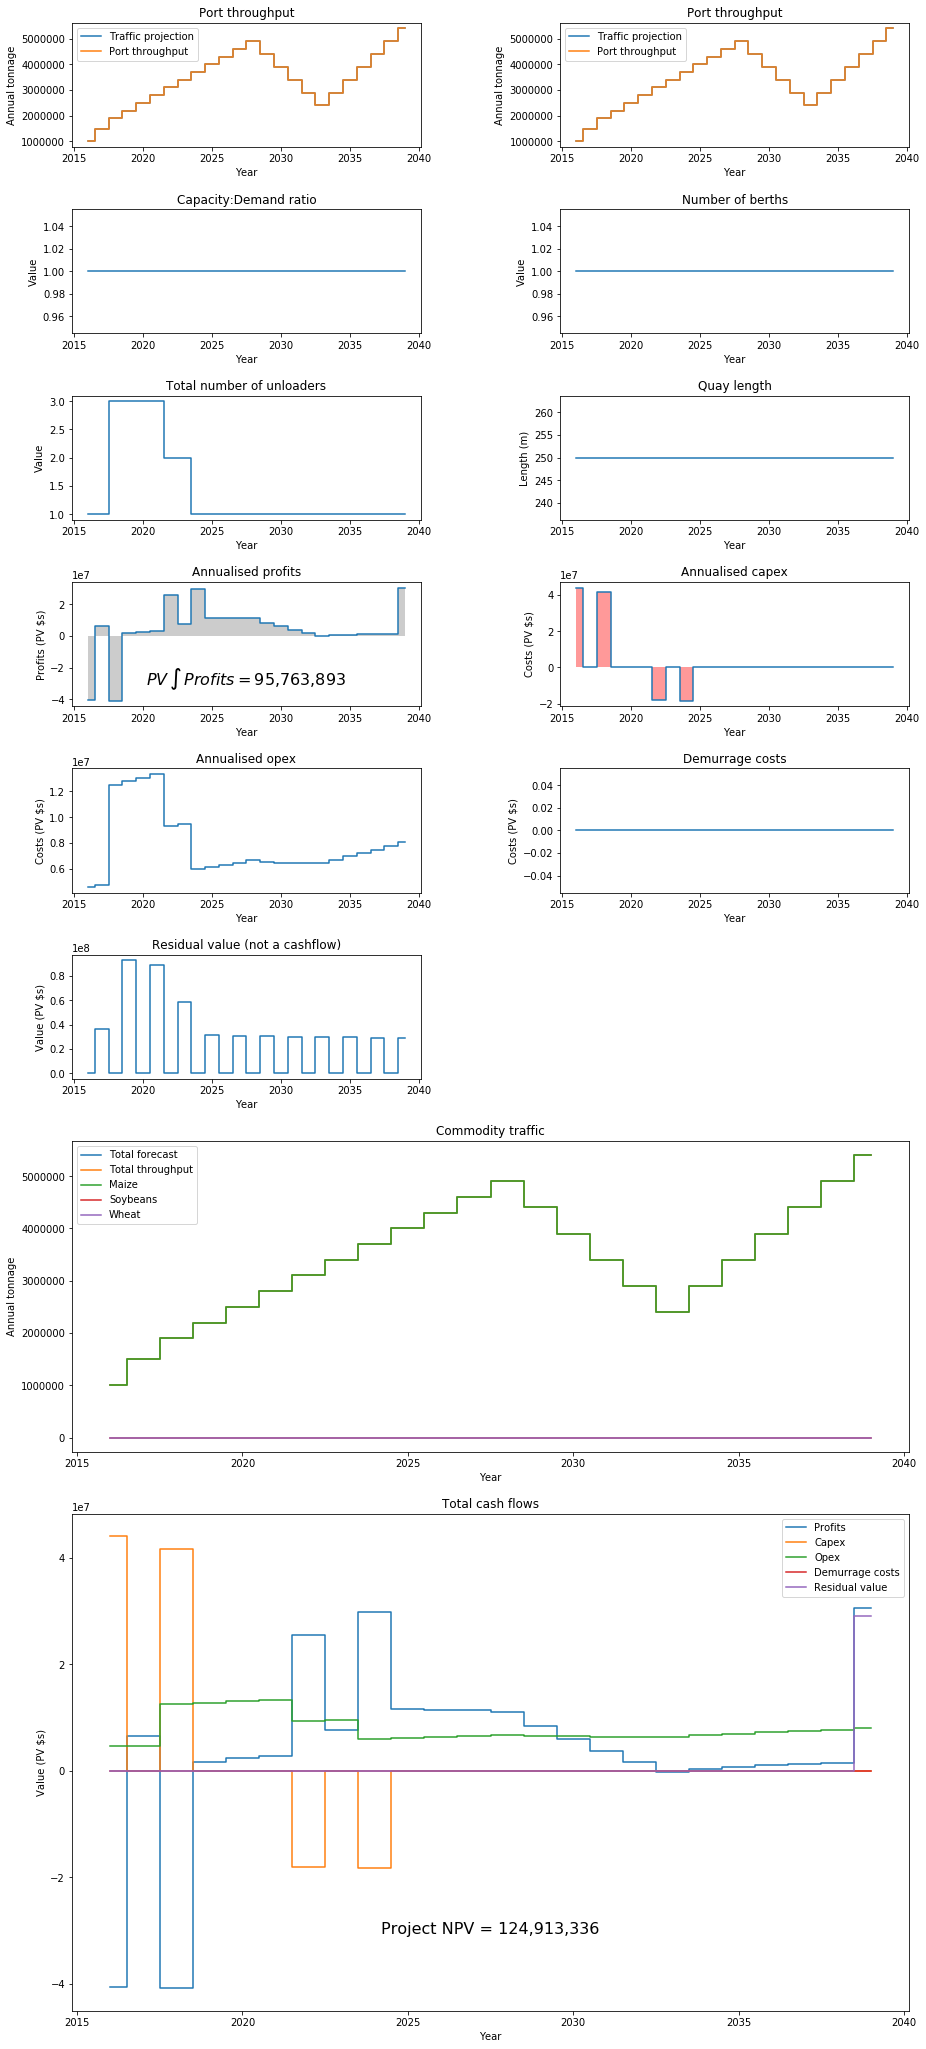

In [45]:
objective_function(2)